In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Database connection:
from sqlalchemy import create_engine

# For scaling and preprocessing
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# For machine learning models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For handling dates
from datetime import datetime

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For working with files and directories
import os

# For exporting and saving results
import pickle

In [5]:
DATABASE_TYPE = 'mysql'
DBAPI = 'pymysql'
ENDPOINT = 'localhost'  
USER = 'root' 
PASSWORD = 'mypassword'  
PORT = 3306  
DATABASE = 'PL_Data'  

connection_string = f"{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{ENDPOINT}:{PORT}/{DATABASE}"

engine = create_engine(connection_string)

In [ ]:
# Step 2: Query the IPF_10082024 table and load it into a DataFrame
query = "SELECT * FROM IPF_10082024"
lifters_df = pd.read_sql(query, engine)

initial_count = lifters_df.shape[0]
print(f"Total number of rows in the IPF table before cleaning: {initial_count}")

key_columns = ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']

lifters_df = lifters_df.dropna(subset=key_columns)

cleaned_count = lifters_df.shape[0]
print(f"Total number of rows in the IPF table after cleaning: {cleaned_count}")

dd_lifters_df = lifters_df[lifters_df['Place'] == 'DD']

dd_count = dd_lifters_df.shape[0]
print(f"Total number of rows in the IPF table where Place is 'DD': {dd_count}")

In [19]:
# Step 3: Create groups of lifters that have competed against drug-disqualified lifters based on:
# Weightclass (implicitly also Sex)
# Division
# Equipment
# Date

# Convert 'Date' column to datetime format
lifters_df['Date'] = pd.to_datetime(lifters_df['Date'], errors='coerce')

# Define the relevant columns for grouping
grouping_columns = ['WeightClassKg', 'Sex', 'Division', 'Equipment', 'MeetName', 'Date']

# Initialize the new 'DDGroupName' column with empty values
lifters_df['DDGroupName'] = None

# Group by these columns
grouped = lifters_df.groupby(grouping_columns)

# Step 2: Loop through each group and assign a descriptive group name if there is a DD lifter
for name, group in grouped:
    if 'DD' in group['Place'].values:
        # Generate a descriptive group name by concatenating the grouping column values
        # Ensure that the Date is formatted properly
        descriptive_group_name = f"{name[0]}_{name[1]}_{name[2]}_{name[3]}_{name[4]}_{name[5].strftime('%Y-%m-%d')}"
        
        # Assign this descriptive group name to all lifters in the group
        lifters_df.loc[group.index, 'DDGroupName'] = descriptive_group_name

# Display the updated DataFrame to check the results
lifters_df.head()


,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,State,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetTown,MeetName,Sanctioned,DDGroupName
0,Jade Millar,F,SBD,Raw,NaN,None,None,Junior,68.15,69,...,None,APLA,IPF,2024-08-04,Australia,NSW,None,XGYM Break All Limits Open IV,Yes,None
1,Jacqueline Pan,F,SBD,Raw,NaN,None,None,Junior,75.40,76,...,None,APLA,IPF,2024-08-04,Australia,NSW,None,XGYM Break All Limits Open IV,Yes,None
2,Ursula Pereira,F,SBD,Raw,25.5,24-34,24-39,Open,47.35,52,...,None,APLA,IPF,2024-08-04,Australia,NSW,None,XGYM Break All Limits Open IV,Yes,None
3,Ruth Czarnecki,F,SBD,Raw,26.0,24-34,24-39,Open,62.70,63,...,None,APLA,IPF,2024-08-04,Australia,NSW,None,XGYM Break All Limits Open IV,Yes,None
4,Erica Saqueton,F,SBD,Raw,NaN,None,None,Open,68.70,69,...,None,APLA,IPF,2024-08-04,Australia,NSW,None,XGYM Break All Limits Open IV,Yes,None


In [21]:
# Step 1: Filter the groups where DDGroupName is not null
dd_grouped_lifters = lifters_df[lifters_df['DDGroupName'].notnull()]

# Step 2: Group by DDGroupName and filter groups
valid_groups = dd_grouped_lifters.groupby('DDGroupName').filter(lambda x: len(x) >= 2 and (x['Place'] != 'DD').any())

# Step 3: Display the first 40 rows of valid groups showing Place, TotalKg, and DDGroupName
print(valid_groups[['Place', 'TotalKg', 'DDGroupName']].head(40))

# Display the total number of valid groups
num_valid_groups = valid_groups['DDGroupName'].nunique()
print(f"Total number of valid groups with at least two competitors and one non-DD competitor: {num_valid_groups}")


     Place  TotalKg                                        DDGroupName
1847    DD      NaN  83_M_Masters 1_Single-ply_World Masters Classi...
1848     1    650.0  83_M_Masters 1_Single-ply_World Masters Classi...
2310     1    525.0  67.5_M_Masters 2_Single-ply_World Masters Powe...
2311     2    520.0  67.5_M_Masters 2_Single-ply_World Masters Powe...
2312     3    472.5  67.5_M_Masters 2_Single-ply_World Masters Powe...
2313    DD      NaN  67.5_M_Masters 2_Single-ply_World Masters Powe...
2329     1    720.0  90_M_Masters 2_Single-ply_World Masters Powerl...
2330     2    712.5  90_M_Masters 2_Single-ply_World Masters Powerl...
2331     3    705.0  90_M_Masters 2_Single-ply_World Masters Powerl...
2332     4    690.0  90_M_Masters 2_Single-ply_World Masters Powerl...
2333     5    652.5  90_M_Masters 2_Single-ply_World Masters Powerl...
2334     6    652.5  90_M_Masters 2_Single-ply_World Masters Powerl...
2335     7    630.0  90_M_Masters 2_Single-ply_World Masters Powerl...
2336  

In [33]:

# Initialize dictionaries to store normalized performance values for each combination
winner_normalized_values_by_category = {}
dd_normalized_values_by_category = {}

# Categories for sex and equipment
sex_categories = ['M', 'F']
equipment_categories = ['Raw', 'Single-ply']

# Initialize dictionaries to store counters for each category
dd_better_than_winner_count_by_category = {}
dd_below_group_average_count_by_category = {}

# Initialize lists for each combination
for sex in sex_categories:
    for equipment in equipment_categories:
        category = f"{sex}_{equipment}"
        winner_normalized_values_by_category[category] = []
        dd_normalized_values_by_category[category] = []
        dd_better_than_winner_count_by_category[category] = 0
        dd_below_group_average_count_by_category[category] = 0


In [34]:
# Iterate over each valid group
for group_name, group in valid_groups.groupby('DDGroupName'):
    # Sum the lifts to get total performance for each competitor
    group['Total_Lifts'] = group['Best3SquatKg'] + group['Best3BenchKg'] + group['Best3DeadliftKg']
    
    # Calculate the group average performance
    group_avg_performance = group['Total_Lifts'].mean()
    
    # Get the sex and equipment type for this group (assuming homogeneity within the group)
    sex = group['Sex'].iloc[0]
    equipment = group['Equipment'].iloc[0]
    category = f"{sex}_{equipment}"
    
    # Get winner's performance (Place = 1)
    winner_performance = group[group['Place'] == '1']['Total_Lifts'].mean()
    
    # Get DD lifter(s) performance
    dd_performance = group[group['Place'] == 'DD']['Total_Lifts'].mean()
    
    # Normalize the performances with respect to the group average
    if group_avg_performance and np.isfinite(group_avg_performance):  # Ensure we don't divide by zero or non-finite values
        normalized_winner_performance = (winner_performance / group_avg_performance) * 100
        normalized_dd_performance = (dd_performance / group_avg_performance) * 100
        
        # Store the values in the appropriate category
        if np.isfinite(normalized_winner_performance):
            winner_normalized_values_by_category[category].append(normalized_winner_performance)
        if np.isfinite(normalized_dd_performance):
            dd_normalized_values_by_category[category].append(normalized_dd_performance)


In [35]:
# Calculate the overall averages for each category
overall_avg_winner_performance_by_category = {}
overall_avg_dd_performance_by_category = {}

for category in winner_normalized_values_by_category:
    if winner_normalized_values_by_category[category] and dd_normalized_values_by_category[category]:
        overall_avg_winner_performance_by_category[category] = sum(winner_normalized_values_by_category[category]) / len(winner_normalized_values_by_category[category])
        overall_avg_dd_performance_by_category[category] = sum(dd_normalized_values_by_category[category]) / len(dd_normalized_values_by_category[category])


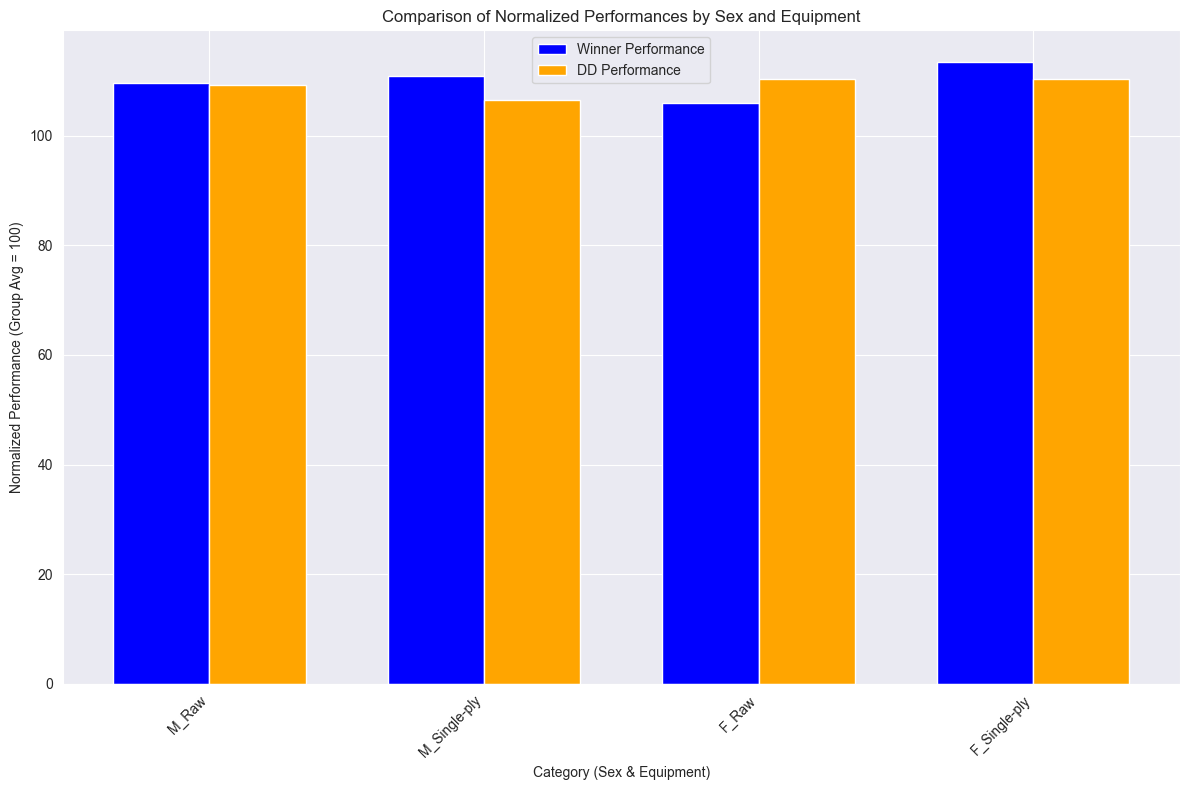

In [36]:
# Create a bar chart for each category
categories = []
winner_performance_values = []
dd_performance_values = []

for category in overall_avg_winner_performance_by_category:
    categories.append(category)
    winner_performance_values.append(overall_avg_winner_performance_by_category[category])
    dd_performance_values.append(overall_avg_dd_performance_by_category[category])

# Plot the bar chart
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(categories))

plt.bar(index, winner_performance_values, bar_width, label='Winner Performance', color='blue')
plt.bar(index + bar_width, dd_performance_values, bar_width, label='DD Performance', color='orange')

plt.xlabel('Category (Sex & Equipment)')
plt.ylabel('Normalized Performance (Group Avg = 100)')
plt.title('Comparison of Normalized Performances by Sex and Equipment')
plt.xticks(index + bar_width / 2, categories, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
# Iterate again to count DD lifters who performed better than the winner or below the group average
for group_name, group in valid_groups.groupby('DDGroupName'):
    # Sum the lifts to get total performance for each competitor
    group['Total_Lifts'] = group['Best3SquatKg'] + group['Best3BenchKg'] + group['Best3DeadliftKg']
    
    # Calculate the group average performance
    group_avg_performance = group['Total_Lifts'].mean()
    
    # Get the sex and equipment type for this group
    sex = group['Sex'].iloc[0]
    equipment = group['Equipment'].iloc[0]
    category = f"{sex}_{equipment}"
    
    # Get winner's performance (Place = 1)
    winner_performance = group[group['Place'] == '1']['Total_Lifts'].mean()
    
    # Get DD lifter(s) performance
    dd_lifters = group[group['Place'] == 'DD']
    
    # Perform comparisons
    for _, dd_lifter in dd_lifters.iterrows():
        dd_performance = dd_lifter['Total_Lifts']
        
        # Compare DD lifter with the winner
        if dd_performance > winner_performance:
            dd_better_than_winner_count_by_category[category] += 1
        
        # Compare DD lifter with the group average
        if dd_performance < group_avg_performance:
            dd_below_group_average_count_by_category[category] += 1


In [38]:
# Calculate percentages for each category
for category in dd_better_than_winner_count_by_category:
    total_dd_lifters_in_category = len(dd_normalized_values_by_category[category])
    if total_dd_lifters_in_category > 0:
        percentage_better_than_winner = (dd_better_than_winner_count_by_category[category] / total_dd_lifters_in_category) * 100
        percentage_below_group_average = (dd_below_group_average_count_by_category[category] / total_dd_lifters_in_category) * 100
        print(f"Category {category}:")
        print(f"Percentage of DD lifters who performed better than the winner: {percentage_better_than_winner:.2f}%")
        print(f"Percentage of DD lifters who performed below the group average: {percentage_below_group_average:.2f}%")
        print('-' * 50)


Category M_Raw:
Percentage of DD lifters who performed better than the winner: 45.35%
Percentage of DD lifters who performed below the group average: 14.53%
--------------------------------------------------
Category M_Single-ply:
Percentage of DD lifters who performed better than the winner: 38.23%
Percentage of DD lifters who performed below the group average: 22.87%
--------------------------------------------------
Category F_Raw:
Percentage of DD lifters who performed better than the winner: 65.85%
Percentage of DD lifters who performed below the group average: 21.95%
--------------------------------------------------
Category F_Single-ply:
Percentage of DD lifters who performed better than the winner: 46.67%
Percentage of DD lifters who performed below the group average: 30.00%
--------------------------------------------------
